![Our Stakeholder, Dwell Development](images/Dwell.png)

# Green Housing Development Analysis

&nbsp;

**Authors:** Stefano Caruso, Holly Gultiano, Raul Torres
***

## Overview

**Disclaimer: this notebook is for a Flatiron School data analysis project, for educational purposes only** 

For the past 17 years, [Dwell Development](https://www.dwelldevelopment.com/home/about/) has been building sustainable houses in the Seattle area. In this project, we use linear regression and other exploratory data analysis techniques to help them plan their next steps

## Business Problem

Seattle's population has been growing every year, largely fueled by the world-renown tech sector here, home of many top companies. 
As the population grows, the price of [rent seems to be growing with it](https://www.kiro7.com/news/local/report-seattle-rent-increased-nearly-19-year-over-year/LMUY74T3FRF5FNEWTG2KBKMJQ4/). Dwell Development wants to respond to this demand by creating new, affordable, multi-family housing for the growing population of tech workers in King County. 

The business problem breaks into three parts: which houses are available in the same zip codes as local tech companies, in order to minimize commute, which features correlate most with price, in order to minimize costs for both Dwell Development and the families on the housing market. With those two criteria met, we then are able to narrow down the selection of properties to find the available properties with the greatest acreage 


## Data Understanding

Dwell Development wants to be able to make a profit from the large influx of people moving to Seattle for tech jobs. They want to be able to develop multi family properties but they do not know the best areas and which qualities correlate more to each other. There are a lot of variables but they only want to focus on the features that correlate strongest to price. We are going to fun simple and multi regression models in order to find the soltion so that Dwell Development does not waist resources in variables that are going to correlate strongly to sell price.


In [70]:
# importing packages used for our analysis
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

%matplotlib inline

#### Source Dataset

&nbsp;

Our housing data csv is located in the [data](./data) folder on this repository
It is a csv file of house data from the King County area of Washington State, and it includes columns for the following features (see [this file for more in-depth descriptions](.data/column_names.md):
> * id, a unique identifier for each house
> * date, when the house was sold 
> * price, sale price
> * bedrooms, number of bedrooms
> * bathrooms, numbedr of bathrooms
> * sqft_living, area of living space for the house
> * sqft_lot, total area of the lot itself
> * floors, number of storeys for the house
> * waterfront, whether or not it is on the water
> * view, quality of view from the house
> * condition, condition when sold
> * grade, quality of house as built
> * sqft_above, total area above ground level
> * sqft_basement, total area below ground level
> * yr_built, the year the house was built
> * yr_renovated, the year the house was renovated, if applicable
> * zipcode, the zip code for the location of the house
> * lat, latitude for the location of the house
> * long, longitude for the location of the house 
> * sqft_living15, average area for the living spaces for the 15 neighboring houses
> * sqft_lot15, average area for the lots for the 15 neighboring houses

For our analysis, we used the "price" variable as the main target for our analysis.

In [71]:
data = pd.read_csv('./data/kc_house_data.csv') 

In [72]:
data.info(), data.corr() # data types and counts, and table of how correlated the features of the raw dataset are

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

(None,
                      id     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
 id             1.000000 -0.016772  0.001150   0.005162    -0.012241 -0.131911   
 price         -0.016772  1.000000  0.308787   0.525906     0.701917  0.089876   
 bedrooms       0.001150  0.308787  1.000000   0.514508     0.578212  0.032471   
 bathrooms      0.005162  0.525906  0.514508   1.000000     0.755758  0.088373   
 sqft_living   -0.012241  0.701917  0.578212   0.755758     1.000000  0.173453   
 sqft_lot      -0.131911  0.089876  0.032471   0.088373     0.173453  1.000000   
 floors         0.018608  0.256804  0.177944   0.502582     0.353953 -0.004814   
 sqft_above    -0.010799  0.605368  0.479386   0.686668     0.876448  0.184139   
 yr_built       0.021617  0.053953  0.155670   0.507173     0.318152  0.052946   
 yr_renovated  -0.012010  0.129599  0.018495   0.051050     0.055660  0.004513   
 zipcode       -0.008211 -0.053402 -0.154092  -0.204786    -0.199802 -0.129586   
 lat     

#### Map of Tech Companies in the King County Area

&nbsp;

sourced from [this blog post](https://flatironschool.com/blog/best-tech-companies-seattle/) covering 30 companies with a lot of draw, including Google and Amazon, as well as some local start-ups

In [73]:
techcompany_name = ['Microsoft', 'Google', 'Expedia', 'Getty', 'Outreach', 'Avalara', 'Amazon', 'Big Fish Games',
                   'Tableau', 'Cray', 'Zulily', 'Redfin', 'Porch', 'SAP Concur', 'F5', 'Xealth', 'Pulumi', 'Apptentive',
                   'Highspot', 'Impinj', 'Upbound', 'Skytap', 'Glowforge', 'Auction Edge', 'GeoEngineers', 'Twillio Zipwhip',
                   'Whitepages', 'Amperity', 'SkyKick', 'PitchBook']

techcompany_coord = {47.6395481:-122.1316979, 47.6491022:-122.3512428, 47.6278727:-122.3771439, 47.5968424:-122.3288311,
                    47.6207149:-122.3623911, 47.5978827:-122.3309175, 47.6149968:-122.3382836, 47.6035842:-122.3375176,
                    47.6478044:-122.3382225, 47.605816:-122.3319745, 47.6142513:-122.3522433, 47.616631:-122.332592,
                    47.5835923:-122.3336612, 47.6161371:-122.1968104, 47.6051851:-122.331118, 47.6019789:-122.3317164,
                    47.6107471:-122.3397581, 47.6110571:-122.3422495, 47.6114079:-122.3478381, 47.6227313:-122.33609, 47.5995348:-122.3313931,
                    47.5980919:-122.3309701, 47.5838846:-122.3328815, 47.5990386:-122.3349373, 47.6141707:-122.3424675,
                    47.6218759:-122.3615888, 47.614592:-122.3391944, 47.6046363:-122.3307528, 47.6210721:-122.3599327, 47.6056348:-122.3321834}

tc_coord_list = list(techcompany_coord.items())

def coordlister(index_num):
    ''' quick function to get the individual coordinates of tech companies for Folium markers'''
    return list(tc_coord_list[index_num])
techmap = folium.Map(location=[47.605, -122.331])

def maplabeler (n):
    folium.Marker(coordlister(n)).add_to(techmap)

for i in range(30):
    maplabeler(i)
    
techmap

## Data Preparation

&nbsp;

In order to produce an accurate and impactful model, we cleaned our data by removing outliers, null values, and fixing some inaccurate entries. We then dropped any features that were not relevant to our model's target prediction, and limited the locations of the houses to only those that were near the tech companies. Selection of which features to drop is shown further in the "Data Modeling section," as we ran simple linear regression models to find the best fits. 

In [74]:
# drop columns that are undesirable desire to our stakeholder 
clean_null = data.drop(columns=['id','date','long','yr_built','condition','view', 'waterfront', 'yr_renovated'], axis=1)
# clean_null.describe()

# locating outliers and removing them
clean_null = clean_null.loc[clean_null['bedrooms'] < 8] 
clean_null = clean_null.loc[clean_null['bathrooms'] < 6] 
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]
clean_null = clean_null.loc[clean_null['price'] < 1500000 ]
clean_null = clean_null.loc[clean_null['bedrooms'] > .99]
clean_null = clean_null.loc[clean_null['bathrooms'] > .99]
clean_null = clean_null.loc[clean_null['sqft_living'] > 600 ]
clean_null = clean_null.loc[clean_null['price'] > 100000 ] # Limiting to the price within the range of our buyer's demand
clean_null = clean_null.loc[clean_null['sqft_lot'] < 100000 ]
clean_null = clean_null.loc[clean_null['floors'] < 2.1 ]

clean_null = clean_null.loc[clean_null['sqft_basement'] != '?' ] 
clean_null['sqft_basement'] = clean_null['sqft_basement'].astype(float)
clean_null['true_sqft'] = clean_null['sqft_living']  - clean_null['sqft_basement']

# creating a new feature of price per sqft
clean_null['price_per_sqft'] = clean_null['price']  / clean_null['true_sqft']

clean_null['grade_ordinal'] = [int(i[0:2].strip()) for i in clean_null['grade']]

In [75]:
# Narrowing down our dataset to include only the houses located in the zip codes from our list of tech companies above
zip_home_size = clean_null.loc[clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164])]
curated_zip = np.array([98052,98102,98103,98105,98109,98119,98121,98134,98164])


In [76]:
# Since the zipcodes column was of numerical type, it affected our regression line inaccurately. Here we use One Hot Encoding to change the zipcodes column into boolean type
zips = clean_null.loc[clean_null['zipcode'].isin(curated_zip)].dropna() 
ohe = OneHotEncoder(sparse=False, drop=[98109]) # the zip code with the highest prices in Seattle. could do 98052, near the Microsoft campus as well
ohe.fit(zips['zipcode'].to_numpy().reshape(-1, 1))
zips_encoded = ohe.transform(zips['zipcode'].to_numpy().reshape(-1, 1))

zipcodes_ohe = pd.DataFrame(zips_encoded, columns=ohe.get_feature_names(), index=zips.index)

# Dropping null values
zip_home_size.dropna(inplace=True)

zip_new_columns = zip_home_size.drop(columns=['zipcode','grade','price_per_sqft','sqft_lot15','sqft_lot','sqft_above'], axis=1)

In [77]:
# Features need to be scaled for the regression model to be accurate
X = zip_new_columns.drop(['price'], axis=1)
ss = StandardScaler().fit(X)
znc_scaled = pd.DataFrame(ss.transform(X), columns=X.columns).dropna() # adding standard scalar to only zip_new_columns, abbreviated as znc

In [78]:
# concatenating two dataframes, znc_scaled and the one hot encoded zipcodes zipcodes_ohe 
zip_ohe_columns = pd.merge(znc_scaled , zipcodes_ohe, how='outer', left_index=True, right_on=znc_scaled.index) #pd.concat([znc_scaled , zipcodes_ohe], axis=1) 
zip_ohe_columns = zip_ohe_columns.drop('key_0', axis=1)

## Data Modeling

&nbsp;

To look for what features in our dataset correlate the most with house pricing in the zip codes associated with local tech companies, we ran a few simple (one variable) linear regression models using Ordinary Least Squares, in order to find the best-fit features, then we created a multiple linear regression model with house price as our target and all the best-fit feature variables (see above) as our source. We chose these features because they showed the highest correlation to house price, showing the optimal choices based on statistical measures such as R² and the Durbin-Watson test.

In [79]:
# First we ran a simple linear regression on one coefficient variable to explore a possible best-fit features
# This created a baseline model to compare our final multiple linear regression to
y = zip_new_columns['price']
x = zip_ohe_columns['sqft_living']
X_c = sm.add_constant(x)


simple_model = sm.OLS(y, X_c)


simple_model_results = simple_model.fit()
print(simple_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     1190.
Date:                Fri, 28 Oct 2022   Prob (F-statistic):          5.39e-191
Time:                        08:58:12   Log-Likelihood:                -19554.
No. Observations:                1455   AIC:                         3.911e+04
Df Residuals:                    1453   BIC:                         3.912e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         6.71e+05   4356.743    154.025      

In [80]:
# Here we created our main model, a multiple linear regression with the target still being 'price'. 
# Our source was the best fit features found through exploratory data analysis and domain knowledge of the housing market in King County 
y = zip_new_columns['price']
X = zip_ohe_columns # ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_basement', 'lat', 'sqft_living15', 'true_sqft', 'grade_ordinal', 'x0_98052','x0_98102', 'x0_98103', 'x0_98105', 'x0_98119']
y = y.dropna()
X = X.dropna()

ols_kch = sm.OLS(y, sm.add_constant(X)).fit()
ols_kch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     263.1
Date:                Fri, 28 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:58:12   Log-Likelihood:                -19104.
No. Observations:                1455   AIC:                         3.824e+04
Df Residuals:                    1441   BIC:                         3.831e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.649e+05   1.44e+04     53.094      0.000    7.37e+05    7.93e+05
bedrooms       5880.4563   4410.340      1.333      0.183   -2770.919    1.45e+04
bathrooms     -5707.5421   5181.052     -1.102      0.271   -1.59e+04    4455.669
sqft_living    6.885e+04   3577.284     19.247      0.000    6.18e+04    7.59e+04
floors        -1.623e+04   4712.083     -3.445      0.001   -2.55e+04   -6990.110
sqft_basement  1.875e+04   3619.389      5.180      0.000    1.16e+04    2.58e+04
lat           -3.076e+04   4324.588     -7.112      0.000   -3.92e+04   -2.23e+04
sqft_living15  3.802e+04   5153.093      7.379      0.000    2.79e+04    4.81e+04
true_sqft      6.279e+04   3859.632     16.269      0.000    5.52e+04    7.04e+04
grade_ordinal  6.503e+04   5244.452     12.400      0.000    5.47e+04    7.53e+04
x0_98052      -2.275e+05   1.65e+04    -13.750      0.000    -2.6e+05   -1.95e+05
x0_98102      -2.506e+04   1.97e+04     -1.273      0.203   -6.37e+04    1.36e+04
x0_98103      -2.803e+04   1.64e+04     -1.712      0.087   -6.02e+04    4094.690
x0_98105       5241.8595   1.68e+04      0.312      0.755   -2.77e+04    3.82e+04
x0_98119       5084.1192   1.68e+04      0.302      0.763   -2.79e+04    3.81e+04
==============================================================================
Omnibus:                      156.428   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.167
Skew:                           0.531   Prob(JB):                    8.13e-108
Kurtosis:                       5.647   Cond. No.                     7.24e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

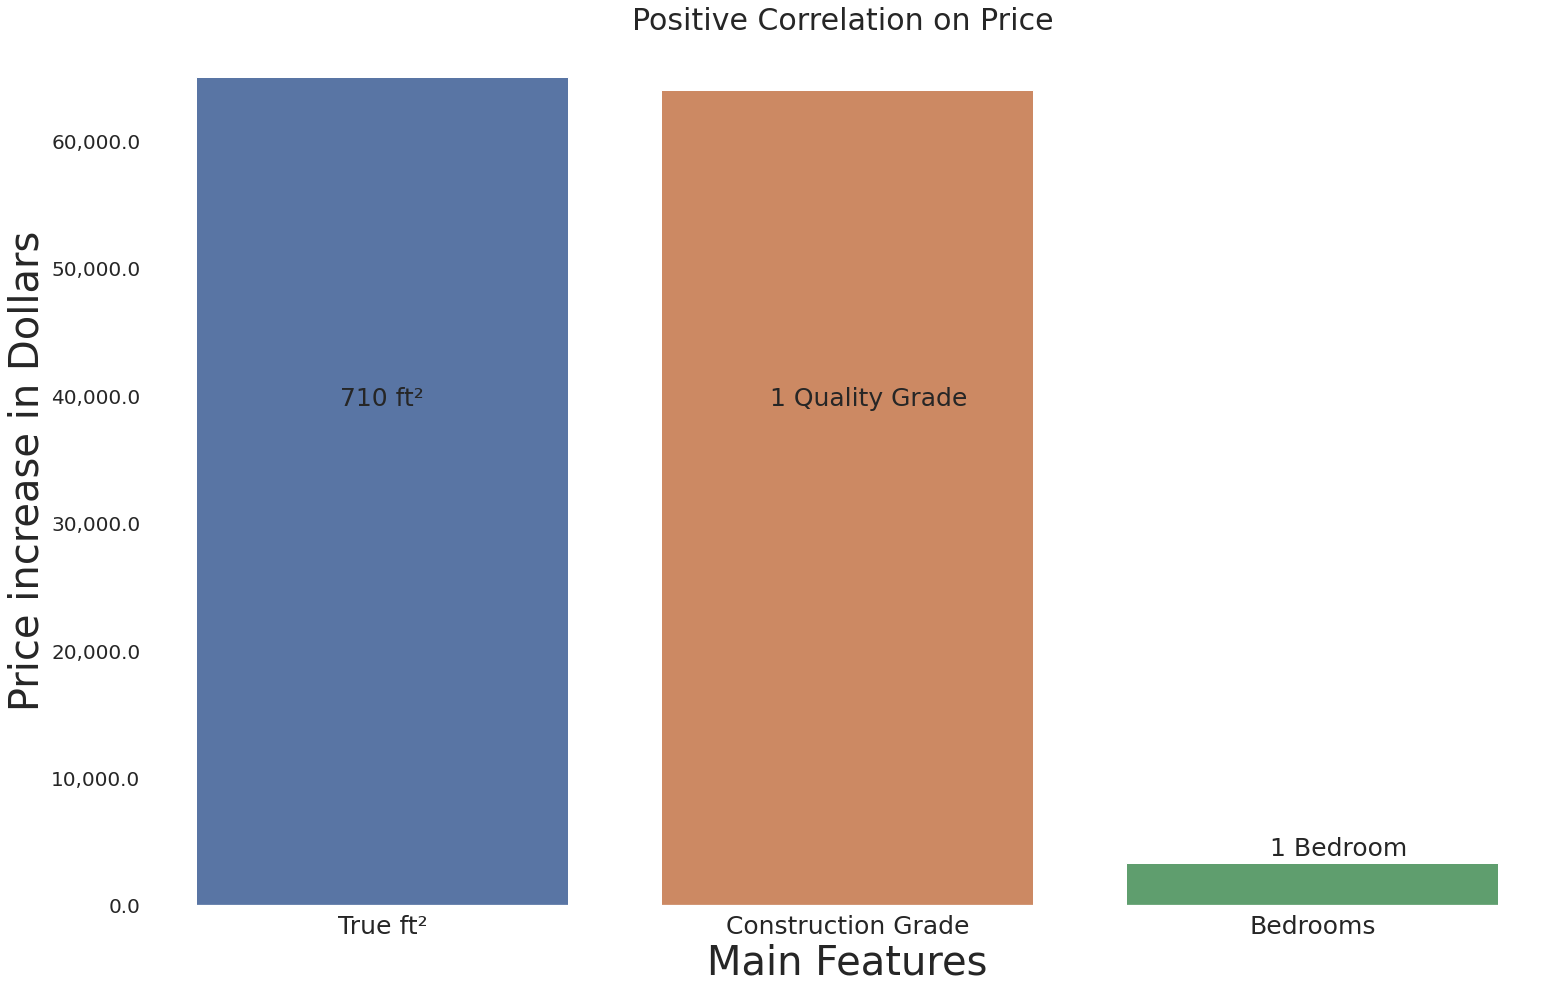

In [95]:
# Plot showing top 3 features 

x_axis = ['True ft²', 'Construction Grade', 'Bedrooms']
y_axis = [65000, 64000, 3300]



fig, ax = plt.subplots(figsize=(25,16))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot( x = x_axis, y = y_axis, );

plt.title('Positive Correlation on Price ', fontsize=30)
plt.xlabel('Main Features', fontsize=40)
plt.ylabel('Price increase in Dollars', fontsize=40)
plt.xticks(rotation=0, fontsize=25)
plt.yticks(fontsize=20)
#plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
ax.annotate('710 ft²',xy=(190, 500), xycoords='axes pixels', fontsize=25)
ax.annotate('1 Quality Grade',xy=(620, 500), xycoords='axes pixels', fontsize=25)
ax.annotate('1 Bedroom',xy=(1120, 50), xycoords='axes pixels', fontsize=25)
plt.show()

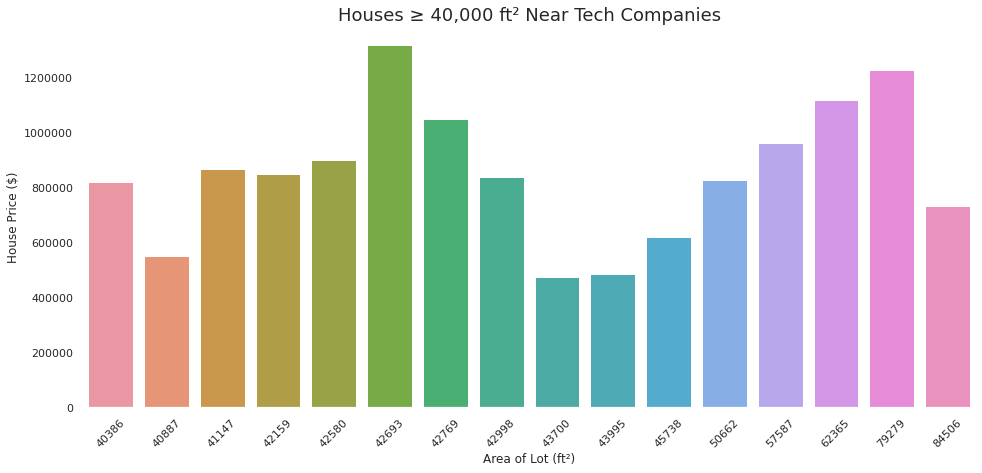

In [82]:
# Plot showing the price range of lots in the range of possibilities to allow for multi-family homes to be developed,
# houses ≥ 40,000 ft², that are located in the same zip codes as our list of tech companies.

zip_lot_size = clean_null.loc[(clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164]))
                              & (clean_null['sqft_lot'] >= 40000)]

fig, ax = plt.subplots(figsize=(16,7))

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'lightgreen'})
sns.barplot(data=zip_lot_size, x='sqft_lot', y='price');

# plt.bar(data=zip_lot_size, x='sqft_living', height='price')
plt.title('Houses ≥ 40,000 ft² Near Tech Companies', fontsize=18)
plt.xlabel('Area of Lot (ft²)')
plt.ylabel('House Price ($)')
plt.xticks(rotation=45)
# plt.yticks(labels=((zip_lot_size['price'])/100))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.show()

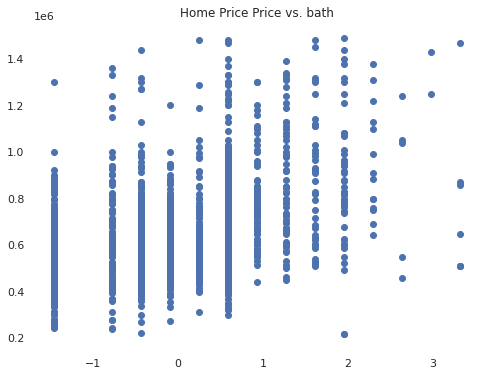

In [96]:
# Exploratory graph to see how number of bathrooms correlates with house price
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

ax.scatter(X['bathrooms'], y)
ax.set_title('Home Price Price vs. bath');

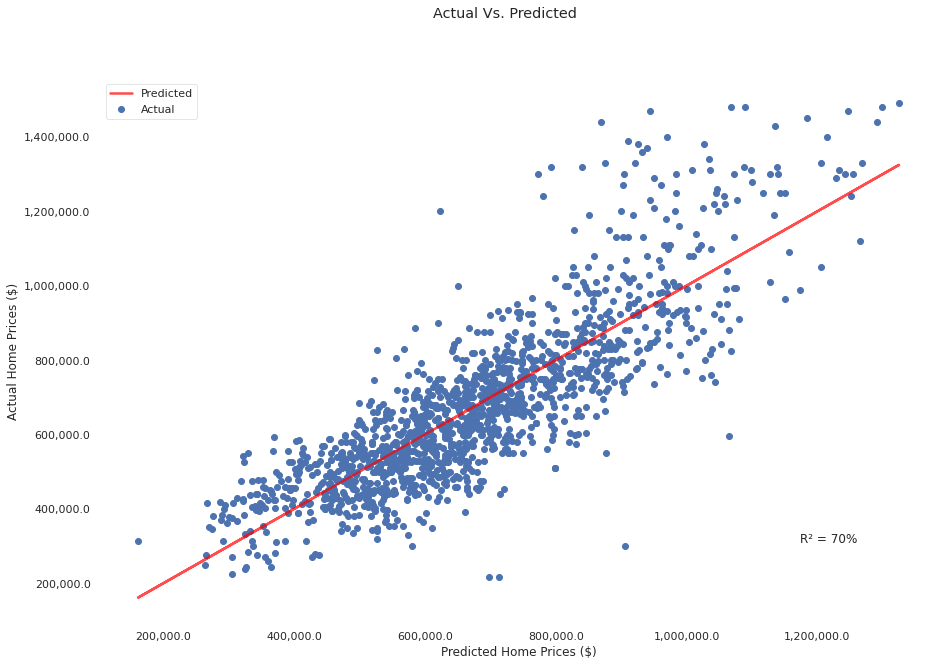

In [103]:
# Plot of final multiple linear regression model, showing regression line in red vs actual house price variance in blue


X_c = sm.add_constant(zip_ohe_columns) #.drop(['price'], axis=1)
y = zip_new_columns['price']

model_preds = ols_kch.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(model_preds, y)
b, a = np.polyfit(model_preds, y, deg=1)
ax.plot(model_preds, a + b * model_preds, color="red", lw=2.5, alpha=0.7) # Plot regression line
# R2 = ax.scatter([0.711],[0.711], color='black', marker='D', s=65, alpha=0.0 )
ax.legend(('Predicted', 'Actual' ), loc="upper left", framealpha=0.5)
# ax.add_artist(legend)
ax.annotate('R² = 70%', xy=(700, 80), xycoords='axes pixels')
ax.set_xlabel('Predicted Home Prices ($)')
ax.set_ylabel('Actual Home Prices ($)')
plt.suptitle('Actual Vs. Predicted')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
# plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.show()


## Evaluation

&nbsp;

Our best fit model is better than the baseline model. The reason for this is because the R² result for the first one is 0.450, compared to our best fit model with an R² of 0.704. As well, the Durbin-Watson (1.958, with 2 being the ideal) is more positively correlated in our best fit model than the baseline model (Durbin-Watson 2.024). 
We found that the three variables with the highest correlation to sale price were True Ft squared, Construction Grade and Bedrooms. 

If this model were to be put to use, Dwell Development will see an increase in business because they are not going to have to use reasources in areas that they don't need


## Conclusions

&nbsp;

There were three features had the strongest impact on house price: true square feet (ft² living area - ft² basement), construction grade, and the number of bedrooms. Given this information, Dwell Development will have measureable data to optimize sale price and profit from their future multi-family home construction.

One limitation to our model was the fairly significant multicolinearity of some of our features. This was seemingly unavoidable due to the inherantly coupled nature of some aspects of houses, i.e., if more bedrooms are added, it is almost always true that more bathrooms would be too, or more floors and living space to accommodate them. We hope to find any possible workarounds to this limitation going forward.

Another factor to consider was the age of the data available. The data available to us went up to the year 2015. House prices have fluctuated a lot in the past few years, especially due to the pandemic's effects on the economy. For future analysis, we would like to mine recent and relevant data and explore trends in pricing over time.